In [2]:
import warnings
import nfl_data_py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import dtreeviz
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, pair_confusion_matrix
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import tree

warnings.filterwarnings("ignore", category=FutureWarning)

In [9]:
earliest_year = 1999
latest_year = 2023

try:
    data = pd.read_csv("./ALLdata.csv")
except IOError:
    # User is running this script without any data. Not a problem -- we can make a call to the
    # data module, it just takes longer.
    data = nfl_data_py.import_pbp_data([x for x in range(earliest_year, latest_year + 1)])

# These are the columns of use for this project
data = data[["posteam", "home_team", "side_of_field", "yardline_100", "quarter_seconds_remaining", "game_seconds_remaining",
             "down", "ydstogo", "play_type", "total_home_score", "total_away_score", "field_goal_result", "weather"]]

print("Number of pbp data values: " + str(len(data)))

# We only want to look at fourth downs -- a team attempting a field goal or punt outside of a fourth down
# is exceedingly rare and wouldn't make this assignment very interesting...
data = data[data["down"] == 4]
print("Number of 4th downs: : " + str(len(data)))

# Looks at what kind of play is being performed.
def get_play(row):
    play = row["play_type"]
    if type(play) != str:
        return None
    if play in ["run", "pass"]:
        return "try"
    elif play in ["field_goal", "punt"]:
        return play
    return None
data["play_type"] = data.apply(get_play, axis=1)
data.dropna(subset=["play_type"], inplace=True)

# Returns a positive value if the team in possession is currently in the lead, and a negative value if the team in
# possession is behind.
def get_spread(row):
    try:
        home_score = int(row["total_home_score"])
        away_score = int(row["total_away_score"])
        if row["posteam"] == row["home_team"]:
            return home_score - away_score
        else:
            return away_score - home_score
    except ValueError:
        return None
data["point_spread"] = data.apply(get_spread, axis=1)

def get_condition(row):
    weather_report = row["weather"]
    if weather_report is None or type(weather_report) != str:
        return None
    weather_report = weather_report.split(" ")[0].lower().replace(",", "")
    if weather_report in ["controlled", "indoors", "artificially", "dome", "roof"]:
        return "Indoors"
    elif weather_report in ["sunny", "fair", "clear", "calm", "good", "hot", "mild", "warm", "light", "sunshine", "nice", "sun"]:
        return "Sunny"
    elif weather_report in ["cloudy", "partly", "mostly", "scattered", "overcast", "cool", "cold", "patchy", "mosly", "cloudly", "coudy", "party"]:
        return "Cloudy"
    elif weather_report in ["gusts", "breezy"]:
        return "Windy"
    elif weather_report in ["hazy", "haze", "foggy", "fog", "hazey"]:
        return "Fog"
    elif weather_report in ["showers", "rain", "raining", "drizzle", "thunderstorms", "misty", "occasional", "overcast/drizzle"]:
        return "Rain"
    elif weather_report in ["frigid", "snow", "snow/fog"]:
        return "Snow"
    else:
        return None
data["condition"] = data.apply(get_condition, axis=1)

def get_wind(row):
    weather_report = row["weather"]
    if weather_report is None or type(weather_report) != str:
        return None
    if row["condition"] == "Indoors":
        return 0
    tokens = weather_report.split(" ")
    if len(tokens) < 2:
        return None
    try:
        output = int(tokens[-2])
    except ValueError:
        return None
    return output
data["wind"] = data.apply(get_wind, axis=1)

print("Number of field goals: " + str(len(data[data["play_type"] == "field_goal"])))
print("Number of punts: " + str(len(data[data["play_type"] == "punt"])))
print("Number of tries: " + str(len(data[data["play_type"] == "try"])))

/var/folders/rs/1b7d_4y96s39hlbsx0_qmqyw0000gn/T/ipykernel_4508/3230962160.py:5: DtypeWarning: Columns (37,38,46,180,181,183,184,190,191,194,195,196,197,198,199,204,205,206,207,208,209,210,211,212,213,214,215,219,220,221,223,225,227,234,235,236,237,238,239,244,245,246,249,250,254,255,256,261,263,264,267,268,269,270,278,284,285,293,294,295,296,297,300,302,303,304,307,333,373,374,375,376,378,380,381,382,388,389,390) have mixed types. Specify dtype option on import or set low_memory=False.


Number of pbp data values: 1198382
Number of 4th downs: : 104587
Number of field goals: 23375
Number of punts: 61984
Number of tries: 13768


In [ ]:
# If we want, we can save our cleaned data back to a csv.
data.to_csv("./cleaned.csv")

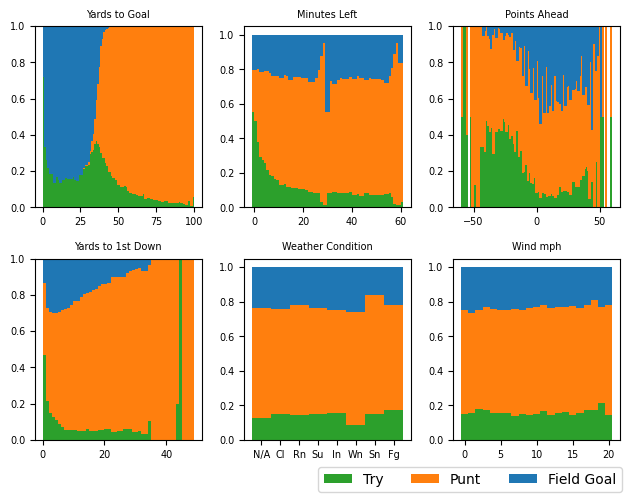

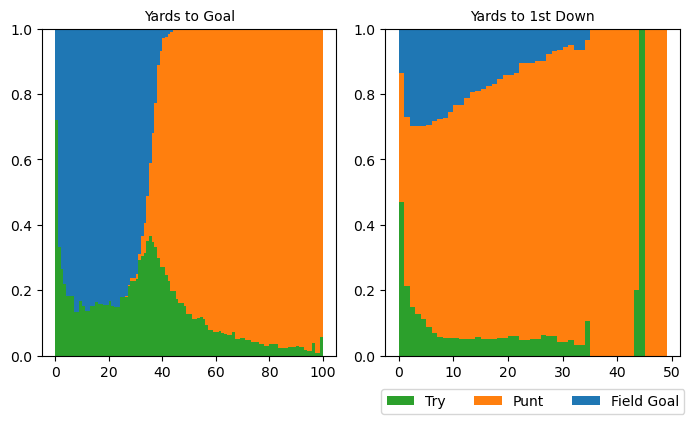

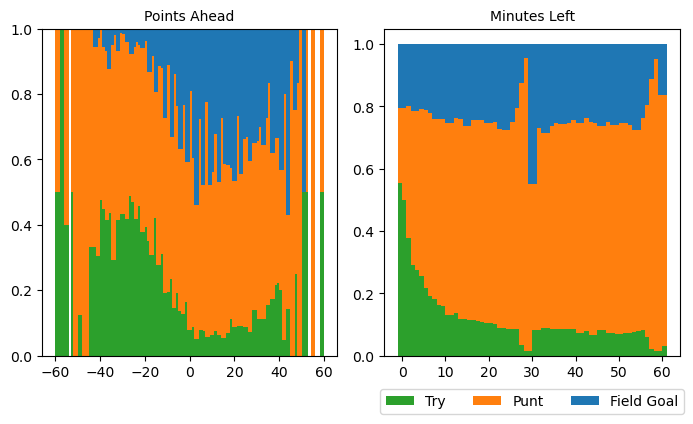

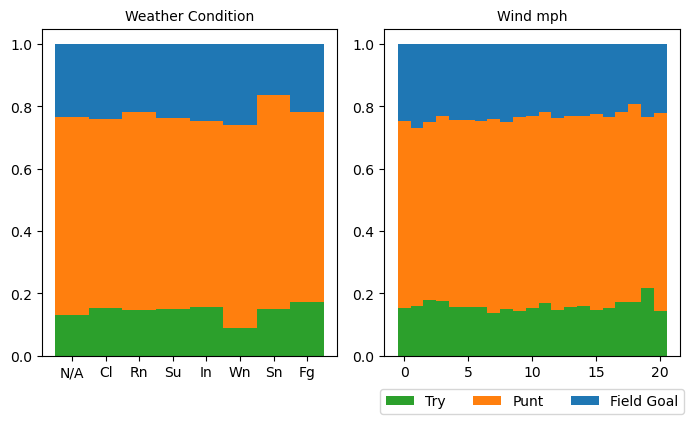

In [3]:
data = pd.read_csv("./cleaned.csv")

# These functions calculate the probabilities of field goals, punts, and tries and prints them to pretty bar charts
# for demo purposes.
def get_counts(row, func):
    enum = {"field_goal": 0, "punt": 1, "try": 2}
    value = func(row)
    if prb_table.get(value) is None:
        prb_table[value] = [0, 0, 0]
    prb_table[value][enum[row["play_type"]]] += 1

def wind_classifier(row):
    if row["wind"] is None:
        return
    try:
        output = int(row["wind"])
    except ValueError:
        return
    if output > 20:
        return
    return output

def weather_classifier(row):
    abbreviations = {"Indoors": "In", "Sunny": "Su", "Cloudy": "Cl", "Windy": "Wn", "Fog": "Fg", "Rain": "Rn", "Snow": "Sn"}
    if row["condition"] is not None and abbreviations.get(row["condition"]) is not None:
        return abbreviations[row["condition"]]
    else:
        return "N/A"
def spread_classifier(row):
    if row["point_spread"] is None:
        return
    try:
        output = int(row["point_spread"])
    except ValueError:
        return
    return output

def time_classifier(row):
    if row["game_seconds_remaining"] is None:
        return
    try:
        output = int((row["game_seconds_remaining"] // 60))
    except ValueError:
        return
    return output

def yardsremaining_classifier(row):
    if row["yardline_100"] is None:
        return
    try:
        output = int(row["yardline_100"])
    except ValueError:
        return
    return output

def yardstogo_classifier(row):
    if row["ydstogo"] is None:
        return
    try:
        output = int(row["ydstogo"])
    except ValueError:
        return
    return output

bar_chart_info = {
    "yardline_100": [yardsremaining_classifier, 2, "Yards to Goal"],
    "game_seconds_remaining": [time_classifier, 2, "Minutes Left"],
    "point_spread": [spread_classifier, 2, "Points Ahead"],
    "ydstogo": [yardstogo_classifier, 2, "Yards to 1st Down"],
    "condition": [weather_classifier, 1, "Weather Condition"],
    "wind": [wind_classifier, 1, "Wind mph"],
}

# All 6 charts in one:

count = 1
fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3)
axis = [ax1, ax2, ax3, ax4, ax5, ax6]

for feature in bar_chart_info:
    plt.subplot(2, 3, count)

    prb_table = {}
    data.apply(lambda row: (get_counts(row, bar_chart_info[feature][0])), axis=1)
    axis[count - 1].set_title(bar_chart_info[feature][2], fontsize=7)
    axis[count - 1].tick_params(axis='both', which='major', labelsize=7)
    prb_df = pd.DataFrame(prb_table, index=["field_goal", "punt", "try"]).transpose()
    for x in ["field_goal", "punt", "try"]:
        prb_df[x + "_pct"] = prb_df[x] / (prb_df["field_goal"] + prb_df["punt"] + prb_df["try"])
    prb_df.reset_index(inplace=True)

    width = bar_chart_info[feature][1]
    plt.bar(prb_df["index"], prb_df["try_pct"], color="tab:green", width=width, label="Try")
    plt.bar(prb_df["index"], prb_df["punt_pct"], bottom=prb_df["try_pct"], color="tab:orange", width=width, label="Punt")
    plt.bar(prb_df["index"], prb_df["field_goal_pct"], bottom=prb_df["try_pct"] + prb_df["punt_pct"], color="tab:blue", width=width, label="Field Goal")
    count += 1

fig.tight_layout()
plt.legend(loc="lower center", ncol=3, bbox_to_anchor=(0.1, -0.325))
plt.show()

# The same charts, just bigger, for the slide deck:

for feature_pair in [["yardline_100", "ydstogo"], ["point_spread", "game_seconds_remaining"], ["condition", "wind"]]:
    count = 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))
    axis = [ax1, ax2]

    for feature in feature_pair:
        plt.subplot(1, 2, count)

        prb_table = {}
        data.apply(lambda row: (get_counts(row, bar_chart_info[feature][0])), axis=1)
        axis[count - 1].set_title(bar_chart_info[feature][2], fontsize=10)
        axis[count - 1].tick_params(axis='both', which='major', labelsize=10)
        prb_df = pd.DataFrame(prb_table, index=["field_goal", "punt", "try"]).transpose()
        for x in ["field_goal", "punt", "try"]:
            prb_df[x + "_pct"] = prb_df[x] / (prb_df["field_goal"] + prb_df["punt"] + prb_df["try"])
        prb_df.reset_index(inplace=True)

        width = bar_chart_info[feature][1]
        plt.bar(prb_df["index"], prb_df["try_pct"], color="tab:green", width=width, label="Try")
        plt.bar(prb_df["index"], prb_df["punt_pct"], bottom=prb_df["try_pct"], color="tab:orange", width=width, label="Punt")
        plt.bar(prb_df["index"], prb_df["field_goal_pct"], bottom=prb_df["try_pct"] + prb_df["punt_pct"], color="tab:blue", width=width, label="Field Goal")
        count += 1

    fig.tight_layout()
    plt.legend(loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.2))
    plt.show()

In [4]:
features = ["yardline_100", "game_seconds_remaining", "point_spread", "ydstogo"]
normal_features = [feature + "_normal" for feature in features]

# For this project, we will use an 80/20 Train/Test split
X = data[features]
y = data["play_type"]

for feature in features:
    X[feature + "_normal"] = X[feature] / abs(X[feature]).max()

train_features, test_features, train_targets, test_targets = train_test_split(X, y, train_size=0.8, test_size=0.2)
test_targets = test_targets.reset_index(drop=True)

print("Training data amount: " + str(len(train_features)))
print("Testing data amount: " + str(len(test_features)))

# For kmeans and knn, we want to normalize the data, as they have different ranges.
train_features_normal = train_features[normal_features]
test_features_normal = test_features[normal_features]

Training data amount: 79301
Testing data amount: 19826


/var/folders/rs/1b7d_4y96s39hlbsx0_qmqyw0000gn/T/ipykernel_4508/40285721.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/rs/1b7d_4y96s39hlbsx0_qmqyw0000gn/T/ipykernel_4508/40285721.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/rs/1b7d_4y96s39hlbsx0_qmqyw0000gn/T/ipykernel_4508/40285721.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

predicted
1    3983
0     658
2      88
Name: count, dtype: int64
predicted
0    6417
2    5503
1     435
Name: count, dtype: int64
predicted
1    1263
2    1018
0     461
Name: count, dtype: int64


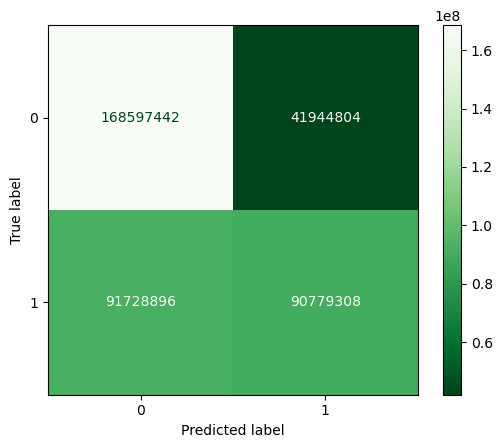

True positives: 168597442
False positives: 41944804
False negatives: 91728896
True negatives: 90779308
Precicion: 0.800777255886213
Recall: 0.647638818627718
F1: 0.7161125109166341


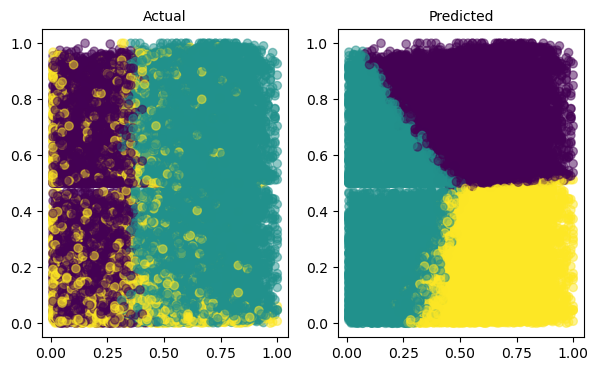

In [5]:
# Trying kmeans first
kmeans = KMeans(n_clusters=3)
kmeans.fit(train_features_normal)
y_pred = kmeans.predict(test_features_normal)
output = pd.concat([pd.DataFrame(y_pred, columns=["predicted"]), test_targets], axis=1)
[print(output[output["play_type"] == category]["predicted"].value_counts()) for category in ["field_goal", "punt", "try"]]

# Let's make a confusion matrix:
CM = pair_confusion_matrix(test_targets, output["predicted"])
cm_display = ConfusionMatrixDisplay(confusion_matrix=CM)
cm_display.plot(cmap="Greens_r", values_format=".0f")
plt.show()

def calc_scores(CM):
    tp, fp, fn, tn = np.ravel(CM)
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    f1 = (2 * p * r) / (p + r)
    return [tp, fp, fn, tn, p, r, f1]

# KMeans did not yield good results. Clusters are too overlapping for useful categorization.
labels = ["True positives", "False positives", "False negatives", "True negatives", "Precicion", "Recall", "F1"]
[print(label + ": " + str(score)) for (label, score) in zip(labels, calc_scores(CM))]

# Let's look at a graph comparing the predicted and actual groupings of points to find out what went wrong (the
# graph just shows 2 of the 4 features, to illustrate the problem)
feature_pair = ["yardline_100_normal", "game_seconds_remaining_normal"]

def colorize(row):
    if row == "field_goal":
        return 1
    elif row == "punt":
        return 2
    else:
        return 3

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

plt.subplot(1, 2, 1)
x = test_features_normal[feature_pair[0]]
y = test_features_normal[feature_pair[1]]
colors = test_targets.apply(colorize)
ax1.scatter(x, y, c=colors, alpha=0.5)
ax1.set_title("Actual", fontsize=10)

plt.subplot(1, 2, 2)
colors = output["predicted"]
ax2.scatter(x, y, c=colors, alpha=0.5)
ax2.set_title("Predicted", fontsize=10)
plt.show()

k: 27


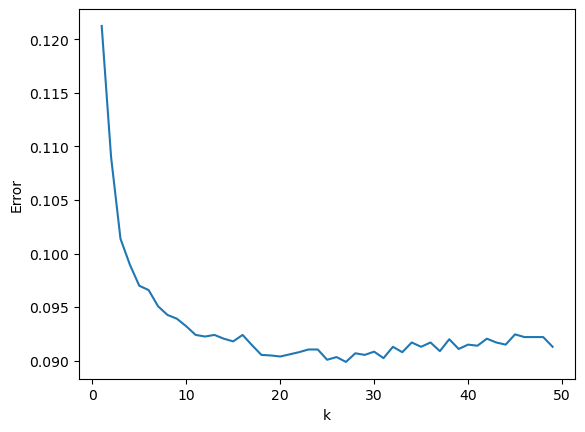

In [6]:
# Trying knn next. First, we need to find out how many neighbors is the optimal number.
error = []
for i in range(1, 50):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_features_normal, train_targets)
    y_pred = knn.predict(test_features_normal)
    error.append(1 - accuracy_score(test_targets, y_pred))
k = error.index(min(error)) + 1
print("k: " + str(k))

# Best k value is ~20
fig, ax = plt.subplots()
ax.tick_params(axis='both', which='major', labelsize=10)
plt.ylabel("Error")
plt.xlabel("k")
plt.plot(range(1, 50), error)

Accuracy:0.910118026833451


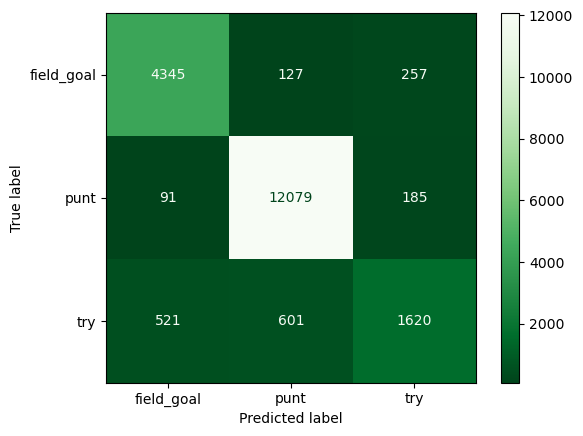

True positives: 185862296
False positives: 24679950
False negatives: 14365038
True negatives: 168143166
Precicion: 0.8827791074291095
Recall: 0.9282563588445921
F1: 0.9049467392400381


[None, None, None, None, None, None, None]

In [7]:
# Now, run the knn model:
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(train_features_normal, train_targets)
y_pred = knn.predict(test_features_normal)
output = pd.concat([pd.DataFrame(y_pred, columns=["predicted"]), test_targets], axis=1)
accuracy = accuracy_score(test_targets, y_pred)
print("Accuracy:" + str(accuracy))

# Make another confusion matrix:
CM = confusion_matrix(test_targets, output["predicted"], labels=["field_goal", "punt", "try"])
cm_display = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=["field_goal", "punt", "try"])
cm_display.plot(cmap="Greens_r")
plt.show()

# KNN yielded significantly better results:
pairwise_CM = pair_confusion_matrix(test_targets, output["predicted"])
[print(label + ": " + str(score)) for (label, score) in zip(labels, calc_scores(pairwise_CM))]

Accuracy:0.9023000100877635


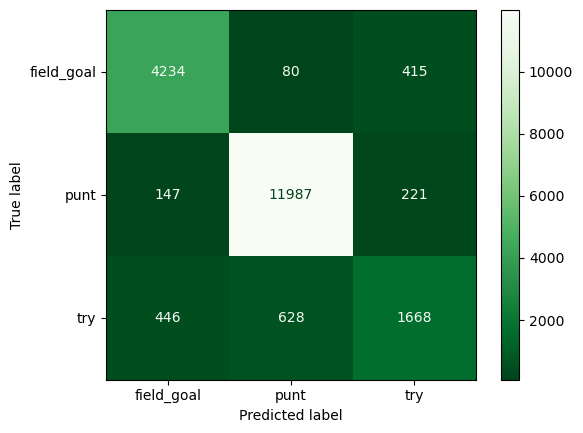

True positives: 186010400
False positives: 24531846
False negatives: 17288506
True negatives: 165219698
Precicion: 0.8834825482008015
Recall: 0.9149601621565047
F1: 0.8989458834678674


/Users/frankietucci/miniconda3/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


In [12]:
# Finally, let's make a decision tree. We don't need to use normalized data for the decision tree, however we need to
# change the string target vals to ints using labelencode.
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(train_targets)
train_targets_encoded = label_encoder.transform(train_targets)
train_features_mod = train_features[features].to_numpy()
clf = tree.DecisionTreeClassifier(max_leaf_nodes=25)
clf = clf.fit(train_features[features], train_targets_encoded)
y_pred = clf.predict(test_features[features])
y_pred = np.vectorize(lambda x: label_encoder.classes_[int(x)])(y_pred)
output = pd.concat([pd.DataFrame(y_pred, columns=["predicted"]), test_targets], axis=1)
accuracy = accuracy_score(test_targets, y_pred)
print("Accuracy:" + str(accuracy))

# Make another confusion matrix:
CM = confusion_matrix(test_targets, output["predicted"], labels=["field_goal", "punt", "try"])
cm_display = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=["field_goal", "punt", "try"])
cm_display.plot(cmap="Greens_r")
plt.show()

# Decision tree performed almost exactly the same as knn did
pairwise_CM = pair_confusion_matrix(test_targets, output["predicted"])
[print(label + ": " + str(score)) for (label, score) in zip(labels, calc_scores(pairwise_CM))]

# Output tree as a svg file.
viz = dtreeviz.model(clf, train_features[features], train_targets_encoded, feature_names=train_features[features].columns, class_names=list(label_encoder.classes_))
graph = viz.view()
graph.save("./tree.svg")